In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers.legacy import Adam, SGD, RMSprop
from tensorflow.keras.optimizers.experimental import Adagrad
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV

import random
import pickle

from keras_visualizer import visualizer

In [2]:
# What version of Python do you have?
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import platform

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU') ) > 0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-13.0.1-arm64-arm-64bit
Tensor Flow Version: 2.12.0
Keras Version: 2.12.0

Python 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:12:31) [Clang 14.0.6 ]
Pandas 2.0.0
Scikit-Learn 1.2.2
GPU is available


### Load the dataset

In [3]:
imputed_train_data = pd.read_csv('/Users/yihongan/Desktop/lr_imputed_train.csv')
imputed_test_data = pd.read_csv('/Users/yihongan/Desktop/lr_imputed_test.csv')

In [5]:
# Define input shapes
text_input_shape = (100,)
num_input_shape = (imputed_train_data.shape[1] - 2,)

# Numerical data
num_train = imputed_train_data.iloc[:, 1:(num_input_shape[0] + 1)].values
num_test = imputed_test_data.iloc[:, 1:(num_input_shape[0] + 1)].values

mean_sd_sc = StandardScaler()
num_train_std = mean_sd_sc.fit_transform(num_train)
num_test_std = mean_sd_sc.transform(num_test)

# Response
y_train = imputed_train_data.iloc[:, (num_input_shape[0] + 1)].values
y_test = imputed_test_data.iloc[:, (num_input_shape[0] + 1)].values.squeeze()

Define the DNN model

In [74]:
def phising_DNNModel(num_layers=5, num_neurons=128, learning_rate=0.001, activation="relu", dropout_rate=0.5, optimizer="Adam"):
    # Define the model
    model = tf.keras.models.Sequential()
    for i in range(num_layers):
        if i == 0:
            model.add(Dense(num_neurons, activation=activation, input_shape=num_input_shape))
        else:
            model.add(Dense(num_neurons, activation=activation))
        model.add(Dropout(dropout_rate)) # drop out layer
            
    model.add(Dense(1, activation='sigmoid'))
    
    # Define optimizer
    if optimizer == "Adam":
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == "Adagrad":
        opt = Adagrad(learning_rate=learning_rate)
    elif optimizer == "RMSprop":
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer == "SGD":
        opt = SGD(learning_rate=learning_rate)
        
    # Compile the model
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy']) 
    return model

In [57]:
early_stopping= EarlyStopping(patience=3, monitor='val_loss')

In [106]:
init_model = phising_DNNModel(num_layers=3, num_neurons=128, learning_rate=0.001, activation="relu", dropout_rate=0.2, optimizer="Adam")
visualizer(init_model, file_name='/Users/yihongan/Desktop/init_DNN', file_format='png', view=True)

In [155]:
init_model.summary()

Model: "sequential_357"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1696 (Dense)          (None, 128)               4480      
                                                                 
 dropout_997 (Dropout)       (None, 128)               0         
                                                                 
 dense_1697 (Dense)          (None, 128)               16512     
                                                                 
 dropout_998 (Dropout)       (None, 128)               0         
                                                                 
 dense_1698 (Dense)          (None, 128)               16512     
                                                                 
 dropout_999 (Dropout)       (None, 128)               0         
                                                                 
 dense_1699 (Dense)          (None, 1)              

In [95]:
init_params = {'kerasclassifier__num_layers': [3],
               'kerasclassifier__num_neurons': [128],
               'kerasclassifier__learning_rate': [0.001],
               'kerasclassifier__activation' : ['relu'],
               'kerasclassifier__dropout_rate' : [0.2],
               'kerasclassifier__optimizer' : ["Adam"]}

init_model = KerasClassifier(build_fn=phising_DNNModel, verbose=1)
init_model_pipeline = make_pipeline(StandardScaler(), init_model)

# Use GridSearchCV to search for the best hyperparameters
init_model_gs = GridSearchCV(estimator=init_model_pipeline, param_grid=init_params, cv=5, scoring='accuracy', verbose=3)

/var/folders/p3/7jx0kjzn67x167nw1jz00d_r0000gn/T/ipykernel_70552/91217559.py:8: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  init_model = KerasClassifier(build_fn=phising_DNNModel, verbose=1)


In [96]:
init_model_gs.fit(num_train, y_train, 
                  kerasclassifier__validation_split=0.1,
                  kerasclassifier__batch_size=32,
                  kerasclassifier__epochs=30,
                  kerasclassifier__callbacks=[early_stopping])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Epoch 1/30
319/319 [==============================] - 16s 42ms/step - loss: 0.3101 - accuracy: 0.8731 - val_loss: 0.2333 - val_accuracy: 0.8985
Epoch 2/30
319/319 [==============================] - 4s 13ms/step - loss: 0.2378 - accuracy: 0.9042 - val_loss: 0.2097 - val_accuracy: 0.9126
Epoch 3/30
319/319 [==============================] - 4s 14ms/step - loss: 0.2167 - accuracy: 0.9131 - val_loss: 0.2068 - val_accuracy: 0.9109
Epoch 4/30
319/319 [==============================] - 4s 12ms/step - loss: 0.2001 - accuracy: 0.9181 - val_loss: 0.1883 - val_accuracy: 0.9162
Epoch 5/30
319/319 [==============================] - 3s 10ms/step - loss: 0.1896 - accuracy: 0.9227 - val_loss: 0.1946 - val_accuracy: 0.9162
Epoch 6/30
319/319 [==============================] - 3s 11ms/step - loss: 0.1837 - accuracy: 0.9238 - val_loss: 0.1842 - val_accuracy: 0.9259
Epoch 7/30
319/319 [==============================] - 4s 13ms/step - loss: 0.1764 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('kerasclassifier',
                                        <keras.wrappers.scikit_learn.KerasClassifier object at 0x841a00520>)]),
             param_grid={'kerasclassifier__activation': ['relu'],
                         'kerasclassifier__dropout_rate': [0.2],
                         'kerasclassifier__learning_rate': [0.001],
                         'kerasclassifier__num_layers': [3],
                         'kerasclassifier__num_neurons': [128],
                         'kerasclassifier__optimizer': ['Adam']},
             scoring='accuracy', verbose=3)

In [97]:
init_model_gs.best_score_

0.928177966101695

Tune hyperparameters by grid search

In [53]:
grid_params = {'kerasclassifier__num_layers': [3, 4, 5],
               'kerasclassifier__num_neurons': [128, 256, 512],
               'kerasclassifier__activation' : ['relu', 'sigmoid'],
                'kerasclassifier__dropout_rate' : [0, 0.2, 0.4],
               'kerasclassifier__learning_rate': [0.001],
               'kerasclassifier__optimizer' : ['Adam']}

tune_model = KerasClassifier(build_fn=phising_DNNModel, verbose=1)
tune_model_pipeline = make_pipeline(StandardScaler(), tune_model)

# Use GridSearchCV to search for the best hyperparameters
tune_model_gs = GridSearchCV(estimator=tune_model_pipeline, param_grid=grid_params, cv=5, scoring='accuracy', verbose=3)

/var/folders/p3/7jx0kjzn67x167nw1jz00d_r0000gn/T/ipykernel_70552/256966658.py:8: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  tune_model = KerasClassifier(build_fn=phising_DNNModel, verbose=1)


In [54]:
tune_model_gs.fit(num_train, y_train, 
                  kerasclassifier__validation_split=0.1,
                  kerasclassifier__batch_size=32,
                  kerasclassifier__epochs=30,
                  kerasclassifier__callbacks=[early_stopping])

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Epoch 1/30
319/319 [==============================] - 6s 15ms/step - loss: 0.2796 - accuracy: 0.8836 - val_loss: 0.2146 - val_accuracy: 0.9064
Epoch 2/30
319/319 [==============================] - 4s 11ms/step - loss: 0.2075 - accuracy: 0.9155 - val_loss: 0.2056 - val_accuracy: 0.9170
Epoch 3/30
319/319 [==============================] - 3s 11ms/step - loss: 0.1873 - accuracy: 0.9244 - val_loss: 0.1862 - val_accuracy: 0.9259
Epoch 4/30
319/319 [==============================] - 3s 10ms/step - loss: 0.1731 - accuracy: 0.9282 - val_loss: 0.1856 - val_accuracy: 0.9197
Epoch 5/30
319/319 [==============================] - 3s 10ms/step - loss: 0.1597 - accuracy: 0.9363 - val_loss: 0.1742 - val_accuracy: 0.9250
Epoch 6/30
319/319 [==============================] - 3s 10ms/step - loss: 0.1512 - accuracy: 0.9386 - val_loss: 0.2020 - val_accuracy: 0.9206
Epoch 7/30
319/319 [==============================] - 3s 10ms/step - loss: 0.144

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('kerasclassifier',
                                        <keras.wrappers.scikit_learn.KerasClassifier object at 0x30b3d8d90>)]),
             param_grid={'kerasclassifier__activation': ['relu', 'sigmoid'],
                         'kerasclassifier__dropout_rate': [0, 0.2, 0.4],
                         'kerasclassifier__learning_rate': [0.001],
                         'kerasclassifier__num_layers': [3, 4, 5],
                         'kerasclassifier__num_neurons': [128, 256, 512],
                         'kerasclassifier__optimizer': ['Adam']},
             scoring='accuracy', verbose=3)

In [55]:
tune_model_gs.best_score_

0.9320621468926553

In [65]:
tune_model_gs.best_params_

{'kerasclassifier__activation': 'relu',
 'kerasclassifier__dropout_rate': 0,
 'kerasclassifier__learning_rate': 0.001,
 'kerasclassifier__num_layers': 3,
 'kerasclassifier__num_neurons': 256,
 'kerasclassifier__optimizer': 'Adam'}

### Comparing optimizers, learning rate and batchs

Optimizer

In [84]:
best_model = phising_DNNModel(num_layers=3, num_neurons=256, learning_rate=0.001, activation="relu", dropout_rate=0, optimizer="Adam")

In [76]:
optimizers = [Adam(0.001), SGD(0.001), RMSprop(0.001)]
opt_histories = []

# Train and evaluate the model with each optimizer
for optimizer in optimizers:
     train_model = tf.keras.models.clone_model(best_model)
     train_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
     # Train the model and monitor the metrics with wandb
     history = train_model.fit(num_train_std, y_train,
                              batch_size=32,
                              epochs=10,
                              verbose=1,
                              validation_split=0.2)
     opt_histories.append(history)

Epoch 1/10
354/354 [==============================] - 11s 24ms/step - loss: 0.2656 - accuracy: 0.8892 - val_loss: 0.2051 - val_accuracy: 0.9184
Epoch 2/10
354/354 [==============================] - 5s 13ms/step - loss: 0.2073 - accuracy: 0.9181 - val_loss: 0.1839 - val_accuracy: 0.9216
Epoch 3/10
354/354 [==============================] - 3s 8ms/step - loss: 0.1825 - accuracy: 0.9266 - val_loss: 0.1761 - val_accuracy: 0.9269
Epoch 4/10
354/354 [==============================] - 4s 10ms/step - loss: 0.1727 - accuracy: 0.9285 - val_loss: 0.1740 - val_accuracy: 0.9322
Epoch 5/10
354/354 [==============================] - 4s 10ms/step - loss: 0.1593 - accuracy: 0.9373 - val_loss: 0.1679 - val_accuracy: 0.9357
Epoch 6/10
354/354 [==============================] - 3s 8ms/step - loss: 0.1504 - accuracy: 0.9397 - val_loss: 0.1809 - val_accuracy: 0.9273
Epoch 7/10
354/354 [==============================] - 3s 8ms/step - loss: 0.1417 - accuracy: 0.9448 - val_loss: 0.1643 - val_accuracy: 0.9336
E

Text(0.5, 0, 'Epoch')

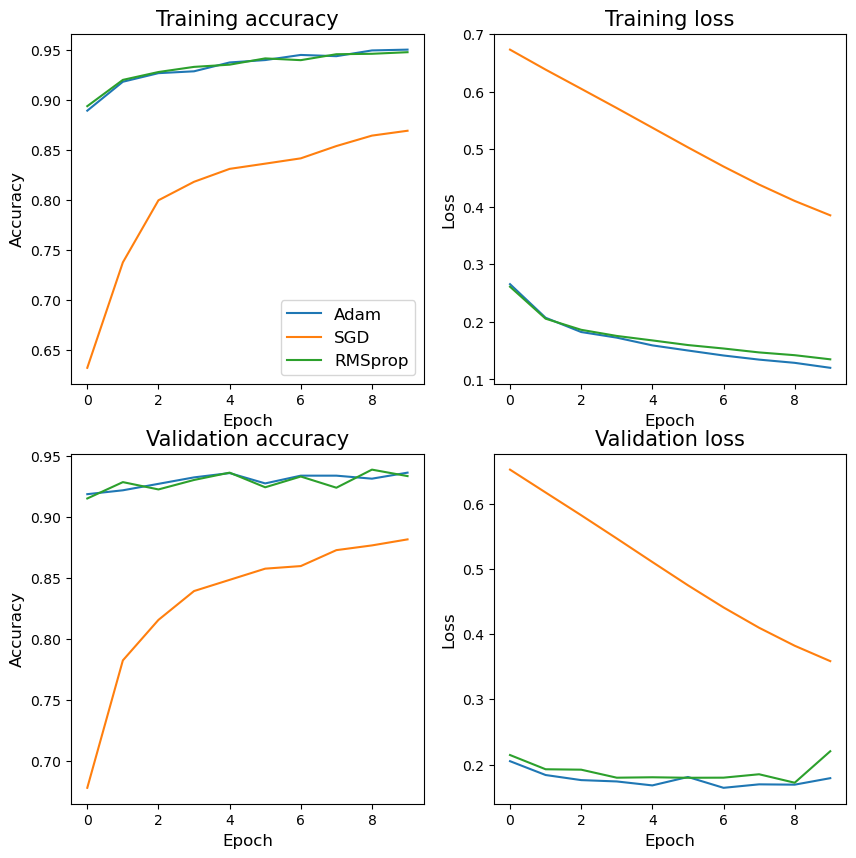

In [77]:
# Plot the training and validation losses for each model

plt.figure(1, figsize=(10, 10))

# Training accuracy
plt.subplot(221)
plt.plot(opt_histories[0].history['accuracy'])
plt.plot(opt_histories[1].history['accuracy'])
plt.plot(opt_histories[2].history['accuracy'])
plt.title('Training accuracy', fontsize=15)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['Adam', 'SGD', 'RMSprop'], loc="best", fontsize=12)

plt.subplot(222)
plt.plot(opt_histories[0].history['loss'])
plt.plot(opt_histories[1].history['loss'])
plt.plot(opt_histories[2].history['loss'])
plt.title('Training loss', fontsize=15)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)

plt.subplot(223)
plt.plot(opt_histories[0].history['val_accuracy'])
plt.plot(opt_histories[1].history['val_accuracy'])
plt.plot(opt_histories[2].history['val_accuracy'])
plt.title('Validation accuracy', fontsize=15)
plt.ylabel("Accuracy", fontsize=12)
plt.xlabel('Epoch', fontsize=12)

plt.subplot(224)
plt.plot(opt_histories[0].history['val_loss'])
plt.plot(opt_histories[1].history['val_loss'])
plt.plot(opt_histories[2].history['val_loss'])
plt.title('Validation loss', fontsize=15)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)

Learning rate

In [78]:
# Define list of optimizers to compare
learning_rates = [0.01, 0.001, 0.0001]
lr_histories = []

# Train and evaluate the model with each optimizer
for learning_rate in learning_rates:
     train_model = tf.keras.models.clone_model(best_model)
     train_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate), metrics=['accuracy'])
     # Train the model and monitor the metrics with wandb
     history = train_model.fit(num_train_std, y_train,
                              batch_size=32,
                              epochs=10,
                              verbose=1,
                              validation_split=0.2)
     lr_histories.append(history)

Epoch 1/10
354/354 [==============================] - 12s 26ms/step - loss: 0.2906 - accuracy: 0.8883 - val_loss: 0.2213 - val_accuracy: 0.9085
Epoch 2/10
354/354 [==============================] - 4s 11ms/step - loss: 0.2462 - accuracy: 0.9042 - val_loss: 0.2218 - val_accuracy: 0.9131
Epoch 3/10
354/354 [==============================] - 4s 10ms/step - loss: 0.2360 - accuracy: 0.9075 - val_loss: 0.1957 - val_accuracy: 0.9188
Epoch 4/10
354/354 [==============================] - 3s 9ms/step - loss: 0.2174 - accuracy: 0.9137 - val_loss: 0.1987 - val_accuracy: 0.9213
Epoch 5/10
354/354 [==============================] - 3s 8ms/step - loss: 0.2072 - accuracy: 0.9169 - val_loss: 0.1804 - val_accuracy: 0.9255
Epoch 6/10
354/354 [==============================] - 3s 9ms/step - loss: 0.1986 - accuracy: 0.9208 - val_loss: 0.2215 - val_accuracy: 0.9255
Epoch 7/10
354/354 [==============================] - 3s 9ms/step - loss: 0.1980 - accuracy: 0.9250 - val_loss: 0.2147 - val_accuracy: 0.9255
Ep

Text(0.5, 0, 'Epoch')

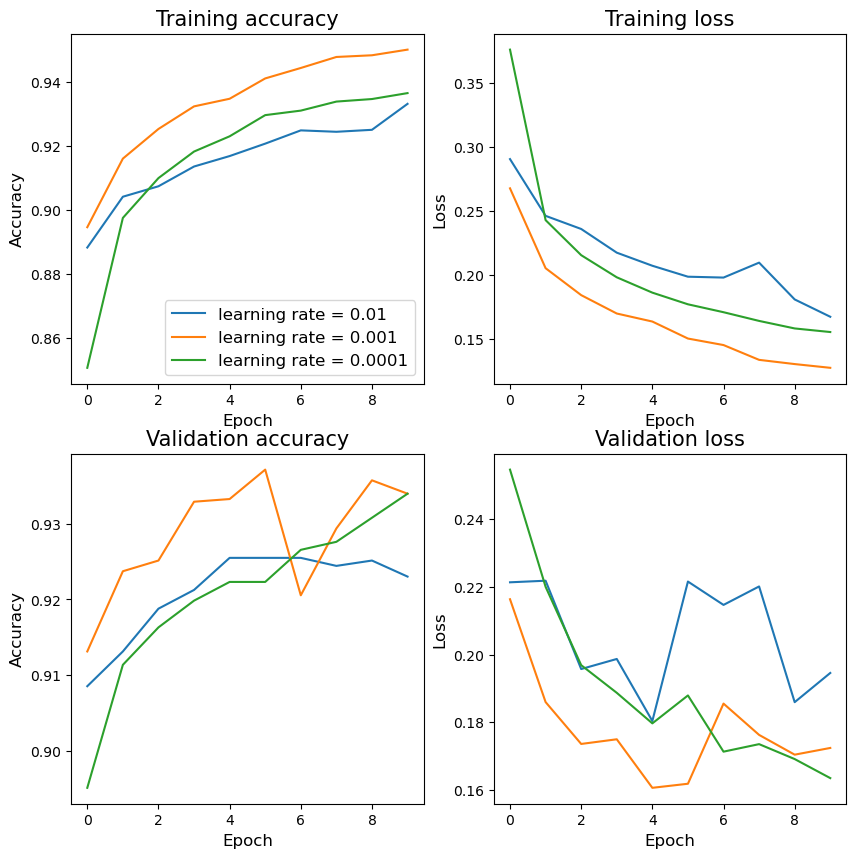

In [79]:
# Plot the training and validation losses for each model

plt.figure(1, figsize=(10, 10))

# Training accuracy
plt.subplot(221)
plt.plot(lr_histories[0].history['accuracy'])
plt.plot(lr_histories[1].history['accuracy'])
plt.plot(lr_histories[2].history['accuracy'])
plt.title('Training accuracy', fontsize=15)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['learning rate = 0.01', 'learning rate = 0.001', 'learning rate = 0.0001'], loc="best", fontsize=12)

plt.subplot(222)
plt.plot(lr_histories[0].history['loss'])
plt.plot(lr_histories[1].history['loss'])
plt.plot(lr_histories[2].history['loss'])
plt.title('Training loss', fontsize=15)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)

plt.subplot(223)
plt.plot(lr_histories[0].history['val_accuracy'])
plt.plot(lr_histories[1].history['val_accuracy'])
plt.plot(lr_histories[2].history['val_accuracy'])
plt.title('Validation accuracy', fontsize=15)
plt.ylabel("Accuracy", fontsize=12)
plt.xlabel('Epoch', fontsize=12)

plt.subplot(224)
plt.plot(lr_histories[0].history['val_loss'])
plt.plot(lr_histories[1].history['val_loss'])
plt.plot(lr_histories[2].history['val_loss'])
plt.title('Validation loss', fontsize=15)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)

Batch size

In [80]:
# Define list of optimizers to compare
batch_sizes = [16, 32, 64]
bs_histories = []

# Train and evaluate the model with each optimizer
for batch_size in batch_sizes:
     train_model = tf.keras.models.clone_model(best_model)
     train_model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
     # Train the model and monitor the metrics with wandb
     history = train_model.fit(num_train_std, y_train,
                              batch_size=batch_size,
                              epochs=10,
                              verbose=1,
                              validation_split=0.2)
     bs_histories.append(history)

Epoch 1/10
708/708 [==============================] - 12s 14ms/step - loss: 0.2601 - accuracy: 0.8961 - val_loss: 0.1983 - val_accuracy: 0.9153
Epoch 2/10
708/708 [==============================] - 6s 9ms/step - loss: 0.2067 - accuracy: 0.9189 - val_loss: 0.1871 - val_accuracy: 0.9248
Epoch 3/10
708/708 [==============================] - 6s 8ms/step - loss: 0.1860 - accuracy: 0.9256 - val_loss: 0.1731 - val_accuracy: 0.9294
Epoch 4/10
708/708 [==============================] - 6s 8ms/step - loss: 0.1718 - accuracy: 0.9311 - val_loss: 0.1774 - val_accuracy: 0.9276
Epoch 5/10
708/708 [==============================] - 6s 9ms/step - loss: 0.1634 - accuracy: 0.9371 - val_loss: 0.1790 - val_accuracy: 0.9326
Epoch 6/10
708/708 [==============================] - 6s 8ms/step - loss: 0.1537 - accuracy: 0.9387 - val_loss: 0.1679 - val_accuracy: 0.9340
Epoch 7/10
708/708 [==============================] - 5s 8ms/step - loss: 0.1440 - accuracy: 0.9455 - val_loss: 0.1677 - val_accuracy: 0.9361
Epoc

Text(0.5, 0, 'Epoch')

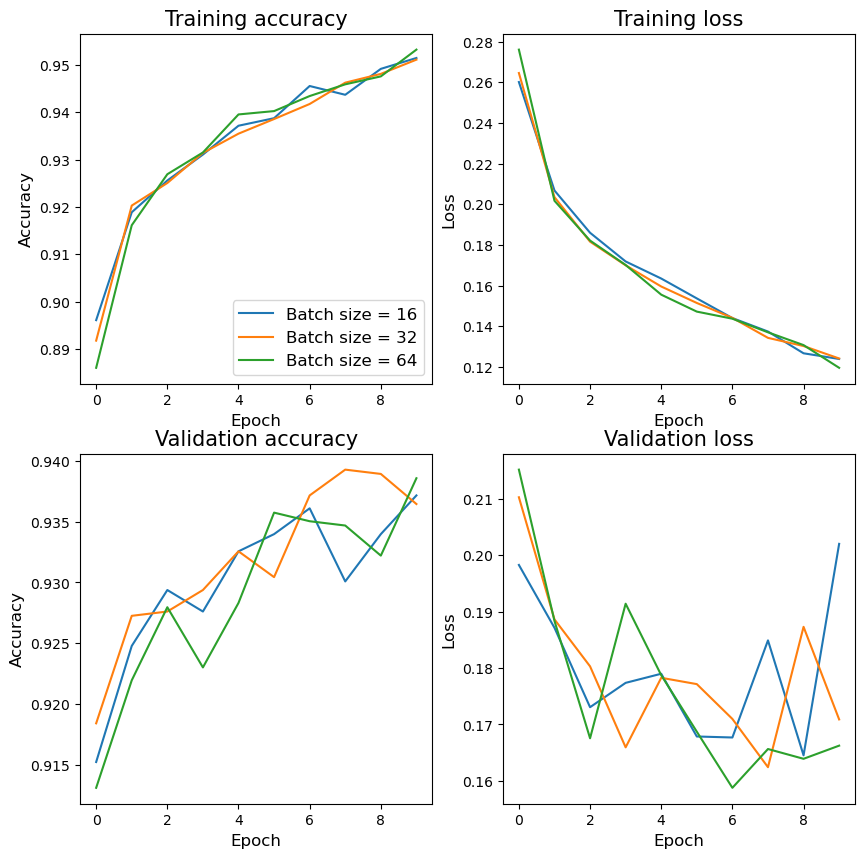

In [81]:
# Plot the training and validation losses for each model

plt.figure(1, figsize=(10, 10))

# Training accuracy
plt.subplot(221)
plt.plot(bs_histories[0].history['accuracy'])
plt.plot(bs_histories[1].history['accuracy'])
plt.plot(bs_histories[2].history['accuracy'])
plt.title('Training accuracy', fontsize=15)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['Batch size = 16', 'Batch size = 32', 'Batch size = 64'], loc="best", fontsize=12)

plt.subplot(222)
plt.plot(bs_histories[0].history['loss'])
plt.plot(bs_histories[1].history['loss'])
plt.plot(bs_histories[2].history['loss'])
plt.title('Training loss', fontsize=15)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)

plt.subplot(223)
plt.plot(bs_histories[0].history['val_accuracy'])
plt.plot(bs_histories[1].history['val_accuracy'])
plt.plot(bs_histories[2].history['val_accuracy'])
plt.title('Validation accuracy', fontsize=15)
plt.ylabel("Accuracy", fontsize=12)
plt.xlabel('Epoch', fontsize=12)

plt.subplot(224)
plt.plot(bs_histories[0].history['val_loss'])
plt.plot(bs_histories[1].history['val_loss'])
plt.plot(bs_histories[2].history['val_loss'])
plt.title('Validation loss', fontsize=15)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)

Retrain the model with best hyperparameters

In [89]:
best_model = phising_DNNModel(num_layers=3, num_neurons=256, learning_rate=0.001, activation="relu", dropout_rate=0, optimizer="Adam")
best_model.summary()

Model: "sequential_345"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1648 (Dense)          (None, 256)               8960      
                                                                 
 dropout_961 (Dropout)       (None, 256)               0         
                                                                 
 dense_1649 (Dense)          (None, 256)               65792     
                                                                 
 dropout_962 (Dropout)       (None, 256)               0         
                                                                 
 dense_1650 (Dense)          (None, 256)               65792     
                                                                 
 dropout_963 (Dropout)       (None, 256)               0         
                                                                 
 dense_1651 (Dense)          (None, 1)              

In [107]:
visualizer(best_model, file_name='/Users/yihongan/Desktop/best_DNN', file_format='png', view=True)

In [90]:
early_stopping = EarlyStopping(patience=3, monitor="val_loss", restore_best_weights=True)
history = best_model.fit(num_train_std, y_train, epochs=100, 
                         batch_size=32, 
                         validation_split=0.1, callbacks=[early_stopping])

Epoch 1/100
399/399 [==============================] - 13s 26ms/step - loss: 0.2603 - accuracy: 0.8956 - val_loss: 0.2227 - val_accuracy: 0.9096
Epoch 2/100
399/399 [==============================] - 5s 12ms/step - loss: 0.1997 - accuracy: 0.9189 - val_loss: 0.1776 - val_accuracy: 0.9223
Epoch 3/100
399/399 [==============================] - 4s 11ms/step - loss: 0.1777 - accuracy: 0.9290 - val_loss: 0.1720 - val_accuracy: 0.9301
Epoch 4/100
399/399 [==============================] - 5s 11ms/step - loss: 0.1676 - accuracy: 0.9324 - val_loss: 0.1653 - val_accuracy: 0.9329
Epoch 5/100
399/399 [==============================] - 4s 10ms/step - loss: 0.1565 - accuracy: 0.9371 - val_loss: 0.1638 - val_accuracy: 0.9322
Epoch 6/100
399/399 [==============================] - 4s 10ms/step - loss: 0.1463 - accuracy: 0.9411 - val_loss: 0.1536 - val_accuracy: 0.9400
Epoch 7/100
399/399 [==============================] - 4s 10ms/step - loss: 0.1373 - accuracy: 0.9466 - val_loss: 0.1632 - val_accuracy

In [91]:
scores = best_model.evaluate(num_test_std, y_test)
print('Test Accuracy:', scores[1])

111/111 [==============================] - 1s 13ms/step - loss: 0.1762 - accuracy: 0.9362
Test Accuracy: 0.9361762404441833


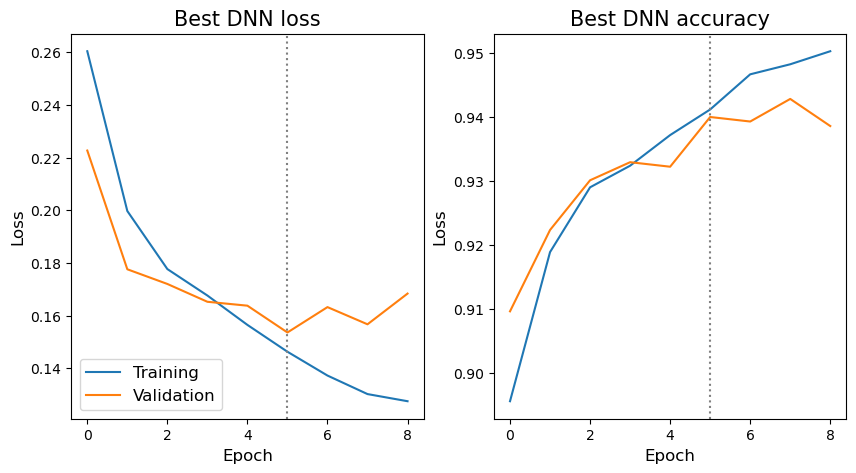

In [92]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Best DNN loss", fontsize=15)
plt.ylabel("Loss", fontsize=12)
plt.xlabel("Epoch", fontsize=12)
plt.axvline(x=5, color='grey',linestyle=":")
plt.legend(["Training", "Validation"], loc="best", fontsize=12)

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Best DNN accuracy", fontsize=15)
plt.ylabel("Loss", fontsize=12)
plt.xlabel("Epoch", fontsize=12)
plt.axvline(x=5, color='grey',linestyle=":")

In [108]:
best_model.save('/Users/yihongan/Desktop/DNN.tf')

INFO:tensorflow:Assets written to: /Users/yihongan/Desktop/DNN.tf/assets


In [109]:
DNN = tf.keras.models.load_model('/Users/yihongan/Desktop/DNN.tf')